### Mixed foraging and compartment model

Broadly
- do equids as trial
    - range of equid body masses, optimal foraging strat
- African herbivore fauna as verification

To do
- rebuild day/night cycle


Current Dynamic
- chewing occurs without mouth filling completely
- stomach and fat behavior is mostly linear
    - processing limited
    - comparison of mean metabolic rate and gamma


Notes
- could set max travel distance



#### outlfow rate thoughts
- kramer 2010 sets a level of gut content at which foraging stops and resumes
- possible components


##### Current State of Variables
1) foraging strategies - Justin's 
2) alpha               - allometric
3) beta                - allometric
4) gamma               - allometric
5) resource gain       - 16.7 kj/g as in pure carb/protein
6) mouth size          - allometric
7) gut size            - allometric, gut type
8) fat max             - allometric
9) velocity            - allometric
10) metabolic rates    - allometric

In [1]:
using Distributed

#addprocs(3);

In [2]:
@everywhere using RCall
@everywhere using JLD2
@everywhere using SharedArrays
@everywhere using Distributions
@everywhere using LinearAlgebra


@everywhere include("~/trait_and_rate_functions.jl") # functions for the resource landscape
@everywhere include("~/space_and_time_functions.jl") # functions for the consumer dynamics


    

In [3]:
using Random
#Random.seed!(42);

In [4]:
number_resources = 2; # only grass and browse in current model

# the following sets the strategy space for foraging preferences
target_values = [0.0, 0.25, 0.5, 0.75, 1.0]; 
strategy_id = repeat(collect(1:number_resources), inner=(length(target_values), 1));
target_weight = repeat(target_values, outer=(number_resources, 1));
strategy_info = Tuple([strategy_id, target_weight]);
number_strategies = length(strategy_id);

# assemble into an array of bernuoulli distributions
bern_array = generate_bern_array(target_weight); 

In [5]:
configurations = 1 # number of configurations per meta-parameter set

t = 0;   #[s]
# it will run for a week if not parallel, will not if parallel
# runs up to 200000s on +1 proc, crashes on more
# will crash kernel on a week of non-parallel unless shit dies early
t_max = 10000; # 2629800s in a month, 604800 in a week

# first pass RLB plant data suggested 0.1-0.3 kgC/m2yr
# experiment with monthly productivity as mean 8.3-25 g/m2month
#resource_gain = [16.7, 16.7];



In [6]:
# grass, browse
# hummel 2008 metabolizable energy
# [grass, dicot browse] 
resource_gain = [10.0, 10.0]#[7.5 ,11.3]; # kj/g
#crude_protein = [15.3, 20.7] # % dry matter
#ndf = [62.8, 43.2,] # % drymatter

# 20.0 t/hc Carbon biomass in tropical grassland/shrubland (2.7annual npp)
# from Tanentzap and Coomes "Carbon storage in terrestrial ecosystems: do
#browsing and grazing herbivores matter?"
# I'm going to assume the available biomass stays fixed and only ratios change between
# scenarios. Later need to account for g C -> dry mass conversion
# conversion of t/hc -> g/m2 is *100
# each scenario has 2000g/m2

# current resource numbers are playing with extreme values to find edge behavior and
# the "useful" resource space where interesting things happen
resource_scenarios = [#grass, browse
                     [[1.0 190.0];  [1.5 191.0]], # forest
                     [[500.0 150.0];  [501.0 151.0]], # shrubland
                     [[100.0 1000.0]; [101.0 1001.0]], # 50:50
                     [[1.0 5.0];  [1.5 5.1]], # savana 
                     [[19.0 1.0];  [20.0 1.5]] # grassland
                     
    ];

# variables for running the simulation later on
number_scenarios = length(resource_scenarios);
scenario_list = 1:number_scenarios;

In [8]:
# need array with input species parameters
# mass [kg], teeth, gut

# currently the species list is just an "antelope" for testing
species_list = [
    80.0 "lophs and non-flat" "colon"
    #1.0  "lophs and non-flat" "colon"
    #10.0  "lophs and non-flat" "colon"
    #100.0  "lophs and non-flat" "colon"
    #1000.0  "lophs and non-flat" "colon"
    #10000.0  "lophs and non-flat" "colon"
];

# takes list of species and gives variable for total number of species
number_species = length(species_list[:,1]);



In [9]:
# collect config_data for testing

# sets array for holding the final output simuation data
body_con_data = SharedArray{Float64}(t_max, 8, number_scenarios,  
    length(strategy_id), number_species, configurations);

# arrays for holding the parameters and distributions generated from organism and 
# landscape traits 
gamma_array = generate_gamma_array(resource_scenarios); # gamma distributions
trait_array = generate_trait_array(species_list); # array of species traits
rate_array = generate_rate_array(species_list); # alpha and beta rates

# array for holding intermediate data
loop_array = generate_loop_array(number_species, number_scenarios, number_strategies,
        configurations);

# at sync makes the processors wait for other processors
#@time @sync @distributed # not currently using parallelization 
@time for index in 1:length(loop_array[:,1])
    
    species = loop_array[index, 1]
    scenario = loop_array[index, 2]
    target = loop_array[index, 3]
    config = loop_array[index, 4]
    
    alpha = [rate_array[species][1], rate_array[species][2]] # intake to mouth rate
    beta = rate_array[species][3]  # mouth to gut rate

    mouth_max = trait_array[species][1] # sets mouth size
    gut_fill_max = trait_array[species][2] # sets gut size
    mrt = trait_array[species][3] # sets mean retention time
    mps = trait_array[species][4] # sets mean particle size
    velocity = trait_array[species][5] # sets velocity
    initial_energy_state = trait_array[species][6] # sets initial fat stores
    basal = trait_array[species][7] # sets basal metabolic rate
    field = trait_array[species][8] # sets field metabolic rate
    costs = [basal, field]; # combines both metabolic rates into a single variable
    fat_max = trait_array[species][9] # sets max fat stores
    
    
    

    resource_stats = resource_scenarios[scenario]; # holds resource attributes
    bernoulli_dist = bern_array[target] # bernoulli distribution for this landscape
    gamma_dist = gamma_array[scenario] # gamma distribution for this landscape

# initializing variables for the run 
t=0;
num_succ = [0,0];

at_food = false; # tracks whether sp is currently at a food item
cropping = false; # tracks whether sp is currently cropping a food item
chewing = false; # tracks whether sp is currently chewing a food item

mouth = [0.0, 0.0];  #[g] # mouth starts empty
gut = [gut_fill_max/4, gut_fill_max/4]  ;  #[g] gut starts at half-capac. 50:50 graze:browse
fat = initial_energy_state;   #[g] # sets fat to initial energy state
        
chosen_resource = 0;
ind = 0
###
#1 while there is time left in the day
    
while t <= t_max && fat >= 0.0 # where there is time left and you're not dead from starvation

    gamma = outflow_rate(gut, gut_fill_max, mrt, mps) # sets the gut-> fat rate 
    #rates = [alpha, beta, gamma]
    ### ###
    #2 if you're hungry
    #if gut <= gut_fill_max && fat <= fat_max  
        
        # if you're not at some food
        if at_food == false;
            # selects a resource to go after

            chosen_resource, travel_time = travel(strategy_id, target_weight, 
                            target, resource_stats, velocity, t, t_max, 
                            bernoulli_dist, gamma_dist)            
                        
            # move to the food
            mouth, gut, fat = update_compartments2(travel_time, mouth, gut,
                fat, [alpha, beta, gamma], costs, resource_gain; travelling=true)
            t += travel_time;
            at_food = true;
                    
                if fat <= 0
                    break
                end
                    
        end
        
        ### ### ###
        #3 if mouth isn't full and you're not chewing and you're at some food
        if sum(mouth) < mouth_max &&  chewing == false && at_food == true  # crop some food
            handling_time = 1/alpha[chosen_resource]        
            
            mouth, gut, fat = update_compartments2((1/handling_time), 
                mouth, gut, fat, [alpha, beta, gamma], costs, resource_gain; cropping=true, resource=chosen_resource)
            
            num_succ[chosen_resource] += 1
            
            t += handling_time
            at_food = false;
                    
                    if fat <= 0
                    break
                end
                    
        end
        
        # if you're mouth is full but not chewing
        if sum(mouth) >= mouth_max && chewing == false 
                    
                # if mouth contents went slightly over max, returns then to max
                mouth = [pool_prop(mouth, 1)*mouth_max, pool_prop(mouth, 2)*mouth_max];
                chewing = true # start chewing
        end
        
        # if you are currently chewing
        if chewing == true && sum(mouth) > beta    
            mouth, gut, fat = update_compartments2((1/beta), mouth, 
                gut, fat, [alpha, beta, gamma], costs, resource_gain; chewing=true)
            t += (1/beta);
                    
                if fat <= 0.0
                    break
                end
                    
        end
        if chewing == true && sum(mouth) <= beta
                chewing = false
            
            end #3 end of if mouth isn't full and you're not chewing
        ### ### ###
                        
        #end #2 end of if you're not hungry
        ### ###    
        
                    
        # add note on why this was necessary
        mouth, gut, fat = update_compartments2(1, mouth, 
                gut, fat, [alpha, beta, gamma], costs, resource_gain)
        
        #if fat <= 0
         #           break
          #      end
                
        t += 1.0;
        
 
#(t_max, 6, number_scenarios,  number_strategies, number_species, configurations)        
        #100000×6×7×10×5×3
        #data_vec = [t, num_succ[1], num_succ[2], mouth, gut, fat]
        if t >= 1#(t_max - 99999)
            ind += 1;
            body_con_data[ind, 1, scenario, target, species, config] = t;
            body_con_data[ind, 2,scenario, target, species, config] = num_succ[1];
            body_con_data[ind, 3,scenario, target, species, config] = num_succ[2];
            body_con_data[ind, 4,scenario, target, species, config] = mouth[1];
            body_con_data[ind, 5,scenario, target, species, config] = mouth[2];
            body_con_data[ind, 6,scenario, target, species, config] = gut[1];
            body_con_data[ind, 7,scenario, target, species, config] = gut[2];
            body_con_data[ind, 8,scenario, target, species, config] = fat;
        end
        
    end  #1 end bout (while t<tmax_bout )
    ###

#time, data, scenarios, strats, species, configurations
    

    end #loop 


# time, graze, browse, mouth, gut, fat

 13.888100 seconds (82.44 M allocations: 2.236 GiB, 1.84% gc time)


#### Code for generating the matrix graph of optimal strategies

In [10]:
#What is all of this

# emptry array for holding scenario, strats, and species for plotting
plot_array=zeros(Float64, number_scenarios, number_strategies, number_species);

# for each scene/strat/species combo, mean avg configs and time
for i=1:number_scenarios, j=1:number_strategies, k=1:number_species
    plot_array[i,j,k] = mean(skipmissing(body_con_data[:,6,i,j,k,:]))
end
# scenarios, strategies, species

# for each combo, find the highest avg over time and configs
optimal_strat = zeros(Float64, number_scenarios, number_species)
for i=1:number_scenarios, j=1:number_species
    optimal_strat[i,j] = findmax(plot_array[i,:,j])[2]
end

In [11]:
# a matrix of me translating the results by hand. 
optimal_strat2 = strategy_matrix_translation(optimal_strat);

In [12]:
species_list_plotting = [1.0, 10.0, 100.0, 1000.0, 10000.0];

#condition_mean = condition_mean_data ./ species_list'

# Body condition mean
R"""
library(fields)
library(RColorBrewer)
pal<-brewer.pal(9,"YlGn")
leg_labels <- c("Graze 100%", "Graze 75%", "Graze 50%", "Graze 25%", "Nearest Resource",
             "Browse 25%", "Browse 50%", "Browse 75%", "Browse 100%")
leg_title <- c("Dietary Preference (Graze to Browse)")

image.plot(y=log10($(species_list_plotting)),x=c($scenario_list) , z=$(optimal_strat2), 
        main='Optimal Foraging Strategies ',
        ylab="Equid Species (log mass kg)", 
    xlab="Resource Landscape - Forest to Grassland Transition",
    legend.lab = leg_title,
    col=pal)
"""

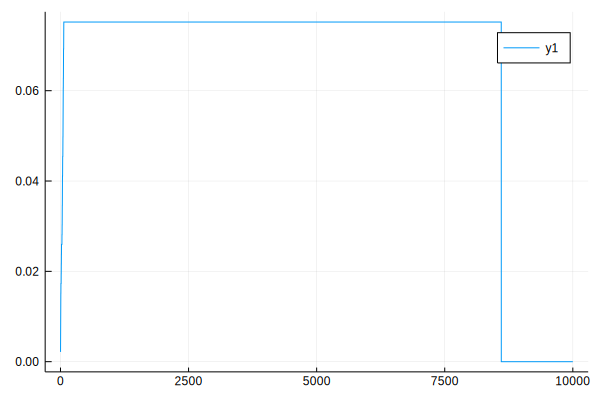

In [14]:
# a lot of the following is commented out and a bit haphazard. It was here as data 
# exploration plotting and I'm not ready to delete it 

# p1 should be plotting an example of mouth data
# p2 should be plotting an example of gut data
# p3 should be plotting an example of fat data

# Data has 8 columns
# 1 - time
# 2 - graze successes 
# 3 - browse successes
# 4 - graze in mouth
# 5 - browse in mouth
# 6 - graze in gut
# 7 - browse in gut
# 8 - fat


using Plots

#time, data, scenarios, strats, species, configurations
p1 = body_con_data[:,4,3,3,1,1]
p2 = body_con_data[:,6,3,3,1,1]
p3 = body_con_data[:,8,3,3,1,1]
#p4 = body_con_data[:,8,3,3,4,4]
#p5 = body_con_data[:,8,3,3,1,5]
#p6 = body_con_data[:,8,3,3,1,1]
#p7 = body_con_data[:,8,3,3,1,2]
#p8 = body_con_data[:,8,3,3,1,3]
#p9 = body_con_data[:,8,3,3,1,4]
#p10 = body_con_data[:,8,3,3,1,5]
#p11 = body_con_data[:,8,3,3,1,1]
#p12 = body_con_data[:,8,3,3,1,2]
#p13 = body_con_data[:,8,3,3,1,3]
#p14 = body_con_data[:,8,3,3,1,4]
#p15 = body_con_data[:,8,3,3,1,5]
#p16 = body_con_data[:,8,3,3,1,1]
#p17 = body_con_data[:,8,3,3,1,2]
#p18 = body_con_data[:,8,3,3,1,3]
#p19 = body_con_data[:,8,3,3,1,4]
#p20 = body_con_data[:,8,3,3,1,5]
#p21 = body_con_data[:,8,3,3,1,1]
#p22 = body_con_data[:,8,3,3,1,2]
#p23 = body_con_data[:,8,3,3,1,3]
#p24 = body_con_data[:,8,3,3,1,4]
#p25 = body_con_data[:,8,3,3,1,5]

x1=p1[findall(x->x!=0, p1)];
x2=p2[findall(x->x!=0, p2)];
x3=p3[findall(x->x!=0, p3)];
#x4=p4[findall(x->x!=0, p4)];
#x5=p5[findall(x->x!=0, p5)];
#x6=p6[findall(x->x!=0, p6)];
#x7=p7[findall(x->x!=0, p7)];
#x8=p8[findall(x->x!=0, p8)];
#x9=p9[findall(x->x!=0, p9)];
#x10=p10[findall(x->x!=0, p10)]
#x11=p11[findall(x->x!=0, p11)];
#x12=p12[findall(x->x!=0, p12)];
#x13=p13[findall(x->x!=0, p13)];
#x14=p14[findall(x->x!=0, p14)];
#x15=p15[findall(x->x!=0, p15)]
#x16=p16[findall(x->x!=0, p16)];
#x17=p17[findall(x->x!=0, p17)];
#x18=p18[findall(x->x!=0, p18)];
#x19=p19[findall(x->x!=0, p19)];
#x20=p20[findall(x->x!=0, p20)]
#x21=p21[findall(x->x!=0, p21)];
#x22=p22[findall(x->x!=0, p22)];
#x23=p23[findall(x->x!=0, p23)];
#x24=p24[findall(x->x!=0, p24)];
#x25=p25[findall(x->x!=0, p25)]

#p = plot(p1);
#plot!(x2)
#plot!(x3)
#plot!(x4)
#plot!(x5)
#plot!(x6)
#plot!(x7)
#plot!(x8)
#plot!(x9)
#plot!(x10)
#plot!(x11)
#plot!(x12)
#plot!(x13)
#plot!(x14)
#plot!(x15)
#plot!(x16)
#plot!(x17)
#plot!(x18)
#plot!(x19)
#plot!(x20)
#plot!(x21)
#plot!(x22)
#plot!(x23)
#plot!(x24)
#plot!(x25)

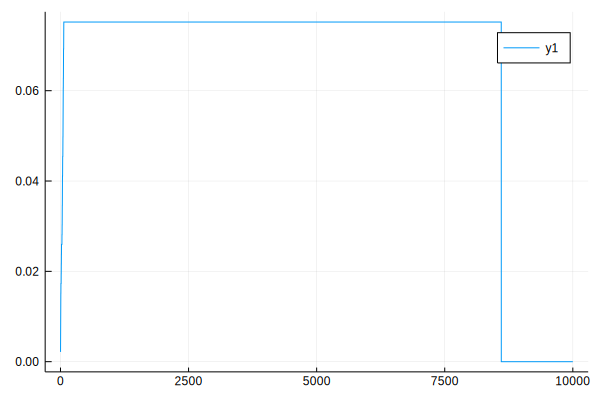

In [21]:
# mouth example
plot(p1)

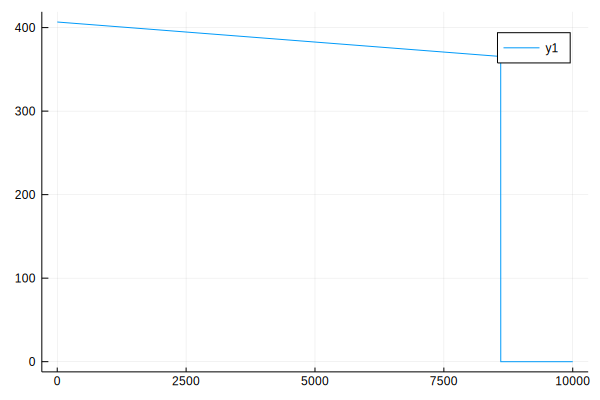

In [16]:
# gut example
plot(p2)

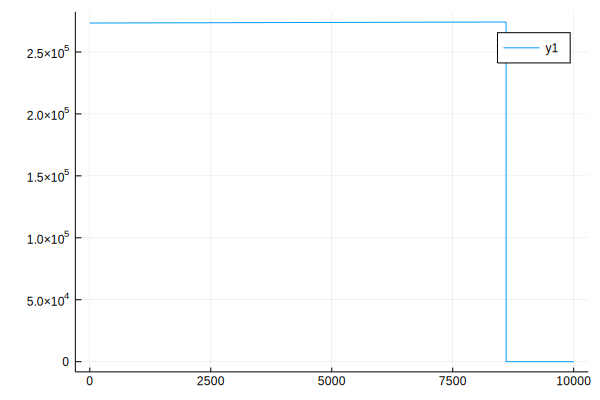

In [17]:
# fat example
plot(p3)

#time, data, scenarios, strats, species, configurations

using RCall
R"""
par(cex=0.6, mai=c(0.8,0.5,0.2,0.5))
par(mfrow=c(3,1)) 
 #layout(matrix(c(1,1,1), 3, 1, byrow = TRUE), heights=c(20,20,20))

plot($x,$y1, type='l', main="Mouth Content of 1kg Forager", 
    xlab="Time (s)", ylab="Forager Mouth Content (g)", 
    ylim = c(0, 10.0))#,xlim = c(6, 10))

plot($x,$y2, type='l', main="Gut Content of 1kg Forager", 
    xlab="Time (s)", ylab="Forager Gut Content (g)", 
    ylim = c(0, 2000))#,xlim = c(6, 10))

plot($x,$y3, type='l', main="Body Condition of 1kg Forager ", 
    xlab="Time (s)", ylab="Forager Body Condition (kJ)", 
    ylim = c(0, 500000))#,xlim = c(6, 10))



"""